# Child Mind Institute - Problematic Internet Usage Kaggle Competition

## Introduction - Problem Definition

The Child Mind Institute has collected data on the physical activity habits of children and adolescents from various means including surveys, physical fitness tests, and actigraphy (a research-grade biotracker of physical activity). Can this data be used to predict the level of problematic internet usage that an individual may display? 

## Data Preparation

Connecting to the competition datasets on Kaggle and importing necessary libraries/packages:

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.semi_supervised import LabelSpreading, SelfTrainingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import  make_scorer
import plotly.express as px
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

In [2]:
from concurrent.futures import ThreadPoolExecutor
import os
from tqdm import tqdm
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

100%|██████████| 2/2 [00:00<00:00,  7.77it/s]


## Data Exploration

Viewing the contents of the various datasets:

In [3]:
train_ds =pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
train_ds.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
test_ds =pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
test_ds.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')
data_dict.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [6]:
train_ts.head()

,Stat_0,Stat_1,Stat_2,Stat_3,Stat_4,Stat_5,Stat_6,Stat_7,Stat_8,Stat_9,...,Stat_87,Stat_88,Stat_89,Stat_90,Stat_91,Stat_92,Stat_93,Stat_94,Stat_95,id
0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,...,5.314874,89.422226,0.0,2626.199951,4187.0,8.639500e+13,7.0,2.0,57.0,0745c390
1,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,...,3.966906,89.080330,1.0,2628.199951,4146.0,8.639500e+13,7.0,2.0,243.0,eaab7a96
2,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,...,5.066334,86.987267,0.0,2618.199951,4183.0,8.636500e+13,7.0,3.0,134.0,8ec2cc63
3,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,...,6.134459,89.976074,0.0,2502.000000,6000.0,8.639500e+13,7.0,4.0,72.0,b2987a65
4,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,...,2.774382,89.300034,0.0,1046.800049,4199.0,8.601500e+13,7.0,4.0,76.0,7b8842c3


In [7]:
train_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 97 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Stat_0   996 non-null    float64
 1   Stat_1   996 non-null    float64
 2   Stat_2   996 non-null    float64
 3   Stat_3   996 non-null    float64
 4   Stat_4   996 non-null    float64
 5   Stat_5   996 non-null    float64
 6   Stat_6   996 non-null    float64
 7   Stat_7   996 non-null    float64
 8   Stat_8   996 non-null    float64
 9   Stat_9   996 non-null    float64
 10  Stat_10  996 non-null    float64
 11  Stat_11  996 non-null    float64
 12  Stat_12  996 non-null    float64
 13  Stat_13  996 non-null    float64
 14  Stat_14  996 non-null    float64
 15  Stat_15  996 non-null    float64
 16  Stat_16  996 non-null    float64
 17  Stat_17  996 non-null    float64
 18  Stat_18  996 non-null    float64
 19  Stat_19  996 non-null    float64
 20  Stat_20  996 non-null    float64
 21  Stat_21  996 non

In [8]:
test_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 97 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Stat_0   2 non-null      float64
 1   Stat_1   2 non-null      float64
 2   Stat_2   2 non-null      float64
 3   Stat_3   2 non-null      float64
 4   Stat_4   2 non-null      float64
 5   Stat_5   2 non-null      float64
 6   Stat_6   2 non-null      float64
 7   Stat_7   2 non-null      float64
 8   Stat_8   2 non-null      float64
 9   Stat_9   2 non-null      float64
 10  Stat_10  2 non-null      float64
 11  Stat_11  2 non-null      float64
 12  Stat_12  2 non-null      float64
 13  Stat_13  2 non-null      float64
 14  Stat_14  2 non-null      float64
 15  Stat_15  2 non-null      float64
 16  Stat_16  2 non-null      float64
 17  Stat_17  2 non-null      float64
 18  Stat_18  2 non-null      float64
 19  Stat_19  2 non-null      float64
 20  Stat_20  2 non-null      float64
 21  Stat_21  2 non-null 

In [9]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [10]:
test_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


In [11]:
#find intersection of IDs in train_ds and train_ts (which IDs are contained in both datasets)

train_ids = train_ds['id'].to_list()
parq_ids = train_ts['id'].to_list()

intersection_ids = (set(train_ids)).intersection(set(parq_ids))
print(len(intersection_ids))

996


In [12]:
data_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Instrument    81 non-null     object
 1   Field         81 non-null     object
 2   Description   81 non-null     object
 3   Type          81 non-null     object
 4   Values        42 non-null     object
 5   Value Labels  32 non-null     object
dtypes: object(6)
memory usage: 3.9+ KB


In [13]:
data_dict['Instrument'].unique()

array(['Identifier', 'Demographics', "Children's Global Assessment Scale",
       'Physical Measures', 'FitnessGram Vitals and Treadmill',
       'FitnessGram Child', 'Bio-electric Impedance Analysis',
       'Physical Activity Questionnaire (Adolescents)',
       'Physical Activity Questionnaire (Children)',
       'Parent-Child Internet Addiction Test', 'Sleep Disturbance Scale',
       'Internet Use'], dtype=object)

In [14]:

# fig = px.parallel_coordinates(df)
# fig.show()

## Data Pre-Processing

#### Feature Selection

##### Feature(s): Physical_BMI, BIA-BIA_BMI

There are two columns containing BMI values from different measures. I want to combine these into one column, taking the mean if both BMIs are not null, or only taking the non-null BMI value. If both BMI values are null, the combined BMI column will remain null.

In [15]:
train_ds['Physical-BMI'].isna().sum()

938

In [16]:
train_ds['BIA-BIA_BMI'].isna().sum()

1969

Since both BMI features contain a decent amount of null values, I will combine them into one feature. If only one of the two is null, I will take the non-null value, if neither is null I will take the mean, and if both are null, the value will remain null.

In [17]:
list_cols = ['BIA-BIA_BMI', 'Physical-BMI']
train_ds['BMI_combined'] = train_ds.loc[:,list_cols].sum(axis=1, skipna=False)
test_ds['BMI_combined'] = test_ds.loc[:,list_cols].sum(axis=1, skipna=False)


In [18]:
train_ds['BMI_combined'] = train_ds['BMI_combined']/2
test_ds['BMI_combined'] = test_ds['BMI_combined']/2

In [19]:
#if only one of the two BMI columns is null, filling in BMI_combined values with the other value
train_ds['BMI_combined'] = train_ds['BMI_combined'].fillna(train_ds['Physical-BMI'])
train_ds['BMI_combined'] = train_ds['BMI_combined'].fillna(train_ds['BIA-BIA_BMI'])

test_ds['BMI_combined'] = test_ds['BMI_combined'].fillna(test_ds['Physical-BMI'])
test_ds['BMI_combined'] = test_ds['BMI_combined'].fillna(test_ds['BIA-BIA_BMI'])

In [20]:
# checking that this worked as intended
BMI_cols = ['BIA-BIA_BMI', 'Physical-BMI', 'BMI_combined']
train_ds[BMI_cols]

,BIA-BIA_BMI,Physical-BMI,BMI_combined
0,16.8792,16.877316,16.878258
1,14.0371,14.035590,14.036345
2,NaN,16.648696,16.648696
3,18.2943,18.292347,18.293323
4,NaN,NaN,NaN
...,...,...,...
3955,16.3642,16.362460,16.363330
3956,NaN,18.764678,18.764678
3957,21.4438,21.441500,21.442650
3958,12.2372,12.235895,12.236548


In [21]:
#dropping the original BMI columns
train_ds = train_ds.drop(columns=['Physical-BMI', 'BIA-BIA_BMI'])
test_ds = test_ds.drop(columns=['Physical-BMI', 'BIA-BIA_BMI'])

##### Feature(s): PCIAT-PCIAT_[01 through 20], PCIAT-PCIAT_Total

In the training dataset, there are features for 20 different PCIAT () scores, as well as a feature for PCIAT Total and the season the PCIAT test was conducted. The PCIAT Total was used by the creators of this dataset to determine 'sii' score and therefore there are no PCIAT values in the test dataset. A model cannot be trained to depend on these features if it is going to then be used to generate predictions for the test data, so I will drop them now. 

In [22]:
train_ds = train_ds.drop(columns=['PCIAT-PCIAT_01', 
                                  'PCIAT-PCIAT_02',
                                 'PCIAT-PCIAT_03',
                                 'PCIAT-PCIAT_04',
                                 'PCIAT-PCIAT_05',
                                  'PCIAT-PCIAT_06',
                                  'PCIAT-PCIAT_07',
                                  'PCIAT-PCIAT_08',
                                  'PCIAT-PCIAT_09',
                                  'PCIAT-PCIAT_10',
                                  'PCIAT-PCIAT_11',
                                  'PCIAT-PCIAT_12',
                                  'PCIAT-PCIAT_13',
                                  'PCIAT-PCIAT_14',
                                  'PCIAT-PCIAT_15',
                                  'PCIAT-PCIAT_16',
                                  'PCIAT-PCIAT_17',
                                  'PCIAT-PCIAT_18',
                                  'PCIAT-PCIAT_19',
                                  'PCIAT-PCIAT_20',
                                  'PCIAT-PCIAT_Total',
                                'PCIAT-Season'
                                 ])

train_ds.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-Height',
       'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMR',
       'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI',
       'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW',
       'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW',

#### Feature correlations and multicollinearity

In [23]:
numeric_data = train_ds.select_dtypes(include=np.number)
numeric_data.head()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,...,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,BMI_combined
0,5,0,51.0,46.0,50.8,NaN,NaN,NaN,NaN,NaN,...,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,3.0,2.0,16.878258
1,9,0,NaN,48.0,46.0,22.0,75.0,70.0,122.0,NaN,...,39.4497,15.4107,27.0552,NaN,2.340,46.0,64.0,0.0,0.0,14.036345
2,10,1,71.0,56.5,75.6,NaN,65.0,94.0,117.0,5.0,...,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0,16.648696
3,9,0,71.0,56.0,81.6,NaN,60.0,97.0,117.0,6.0,...,58.9338,26.4798,45.9966,NaN,2.451,31.0,45.0,0.0,1.0,18.293323
4,18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.04,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# To see the features most correlated with the target (sii):

df=numeric_data.corr().abs().stack().reset_index()

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

df.drop(columns=['level_1', 'level_0'], inplace = True)

df.columns = ['cc']

df.drop_duplicates(inplace=True)

In [25]:
numeric_data.columns

Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
       'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone',
       'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone',
       'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone',
       'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMR',
       'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI',
       'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW',
       'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW',
       'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
       'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 

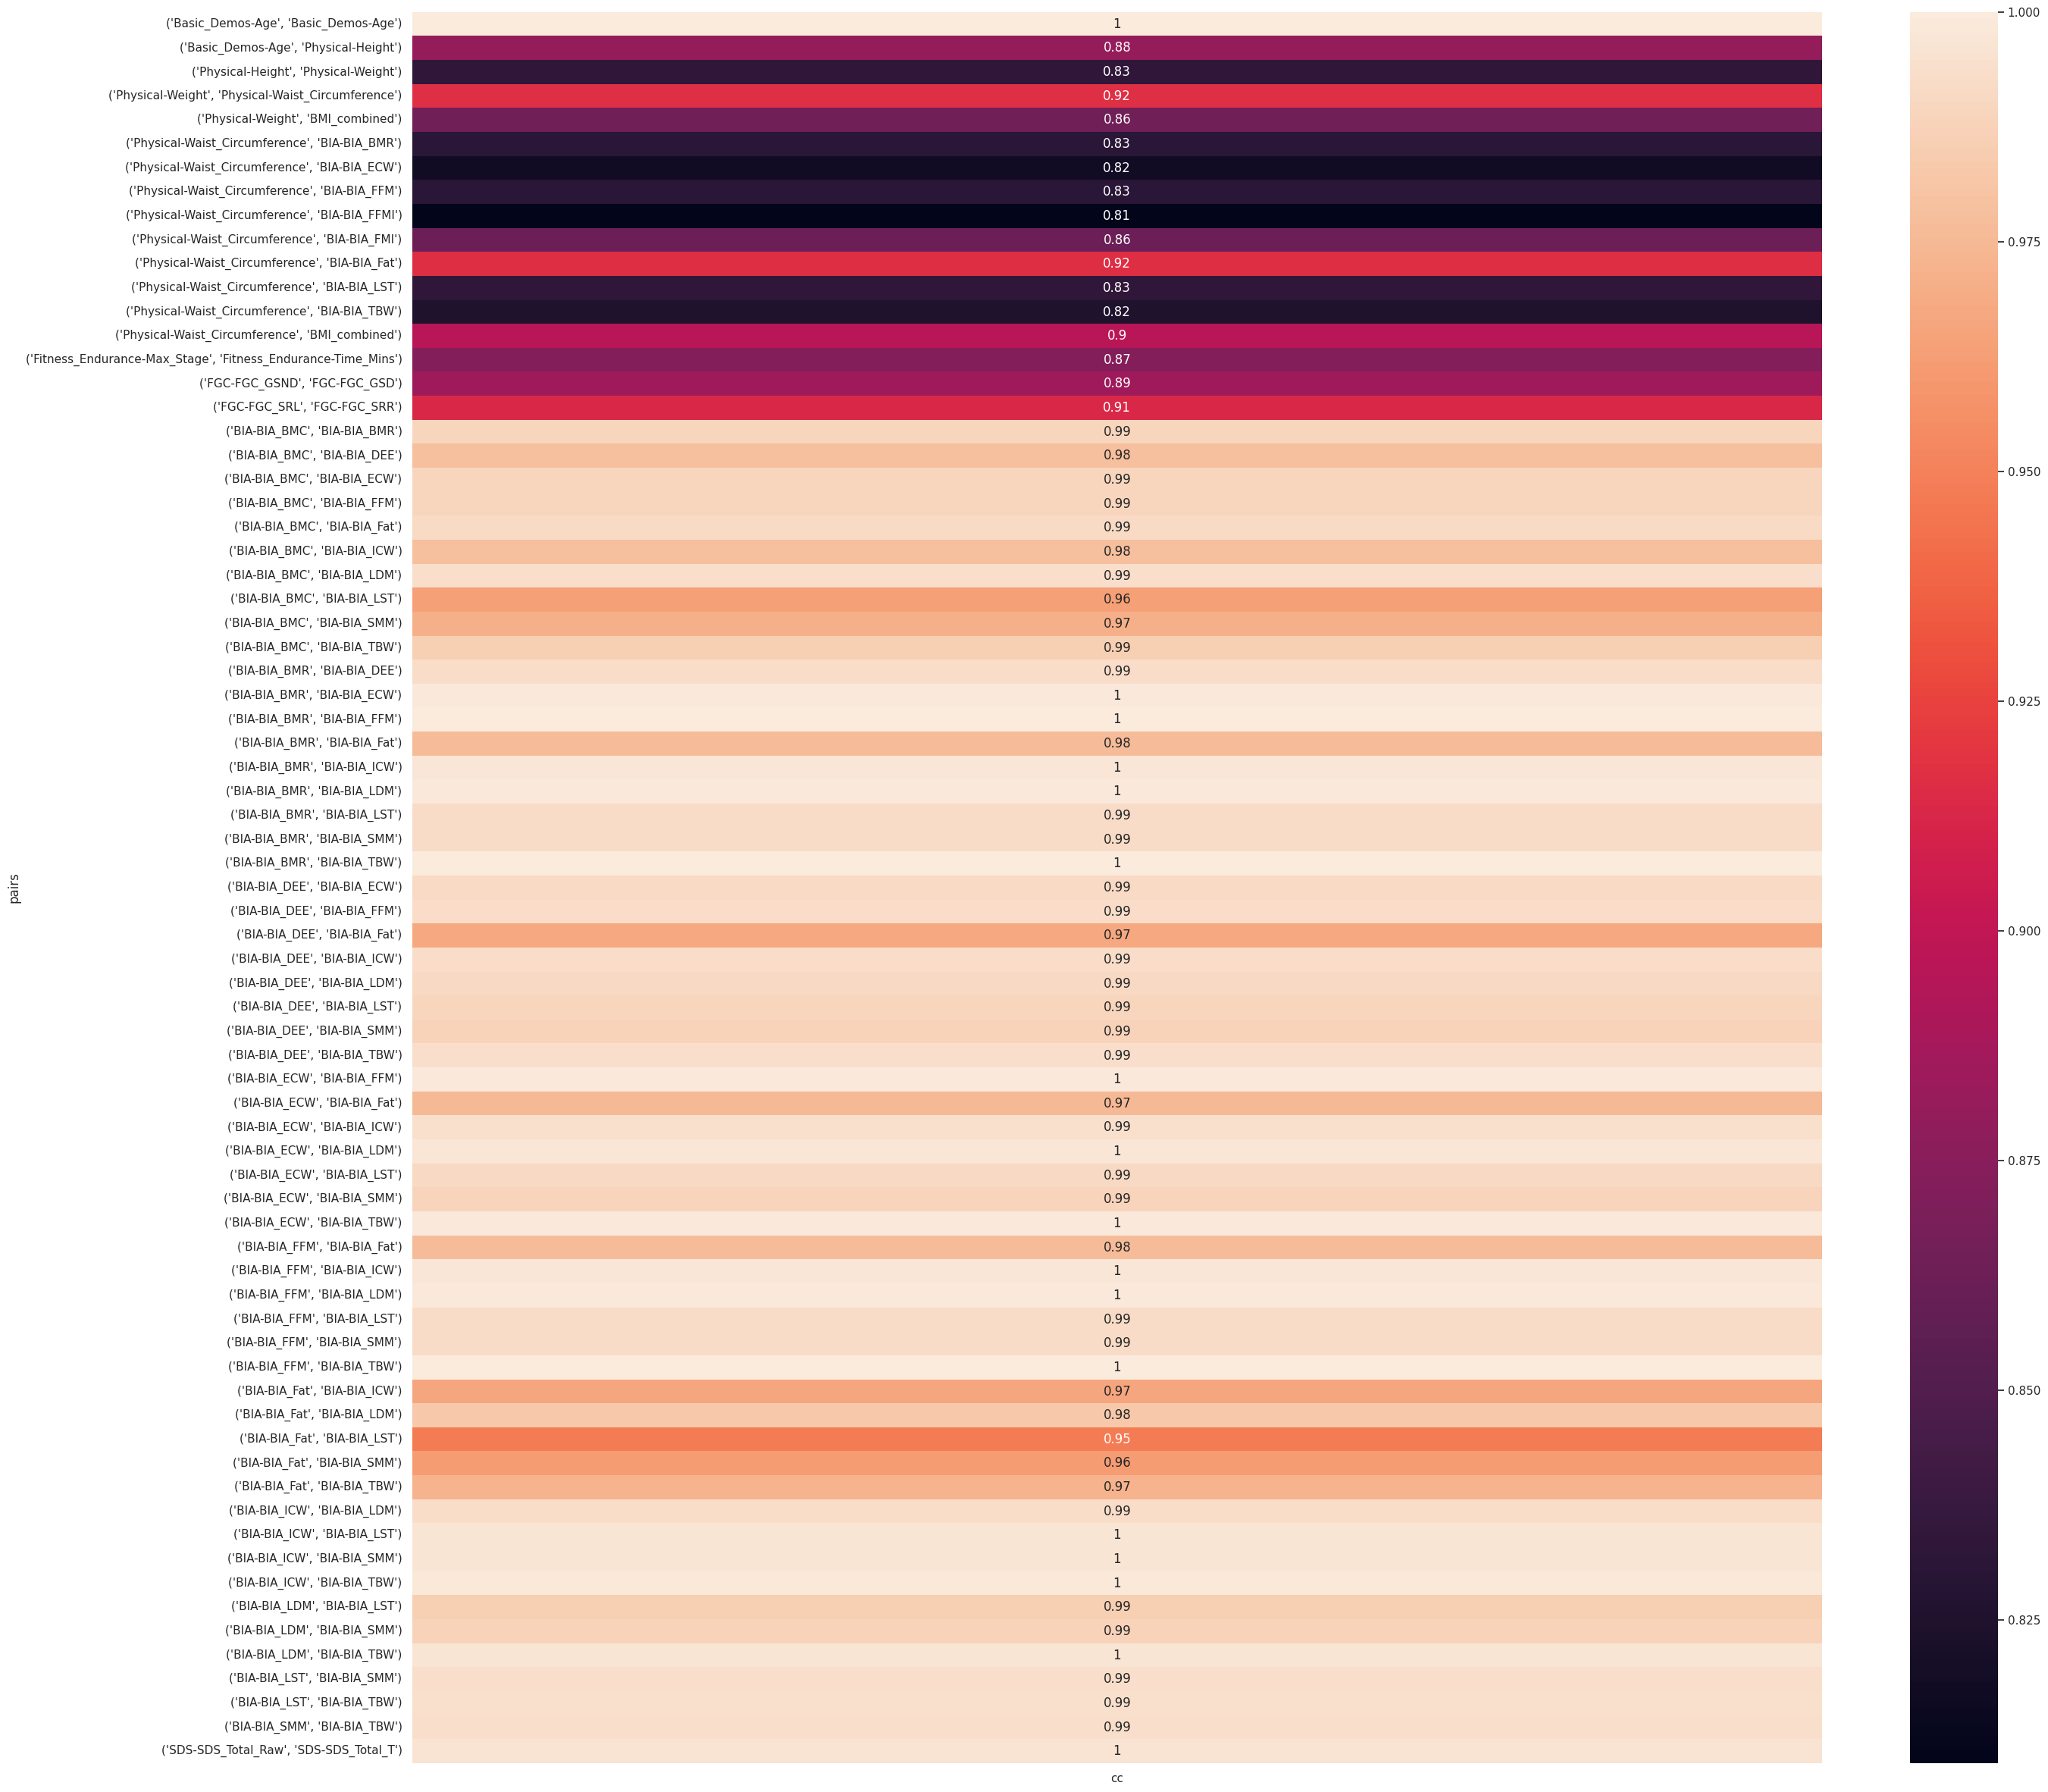

In [26]:
#To see the features most correlated with each other:

top_corr = df[(df.cc>=.80)]

sns.set(rc={'figure.figsize':(30,30)})
sns.heatmap(top_corr, annot=True);

Many of the features are highly or even perfectly correlated with eachother. This means to avoid multicollinearity issues it is best to reduce some of these features, either by dropping them or by combining them via feature engineering.

In [27]:
# dropping redundant/irrelevant features 

#train_ds = train_ds.drop(columns=
                        # ['SDS-SDS_Total_Raw', #We don't need the raw score for SDS Total in addition to the total T score
                         # 'BIA-BIA_ECW', # Total body water (TBW) is just intracellular water (ICW) + extracellular water (ECW), so including all these features is redundant
                         # 'BIA-BIA_ICW',
                         # 'Physical-Height', #BMI is calculated using body height and weight, so including all these features is redundant
                         # 'Physical-Weight',
                         # 'BIA-BIA_FFM', #Removing 'Fat Free Mass' but keeping 'Fat Free Mass Index'
                         # 'BIA-BIA_LDM', #BMR is directly related to both Lean Dry Mass and Total Body Water
                         # 'BIA-BIA_TBW',
                         # 'BIA-BIA_SMM', #Skeletal Muscle Mass is a large part of Lean Soft Tissue, it makes more sense to only keep LST
                         # 'BIA-BIA_DEE', #Daily Energy Expendature (DEE) is a large contributing factor to determining BMR
                         # 'BIA-BIA_Fat', #though not directly used to calculate BMR, body fat percentage and lean soft tissue are almost perfectly correlated with BMR
                         # 'BIA-BIA_LST'
                          
                         
                         
                         #])

In [28]:
# To make sure all perfectly correlated features are eliminated
numeric_data2 = train_ds.select_dtypes(include=np.number)
df2=numeric_data2.corr().abs().stack().reset_index()
# .sort_values(0, ascending=False)
df2['pairs'] = list(zip(df2.level_0, df2.level_1))

df2.set_index(['pairs'], inplace = True)

df2.drop(columns=['level_1', 'level_0'], inplace = True)

df2.columns = ['cc']

df2.drop_duplicates(inplace=True)

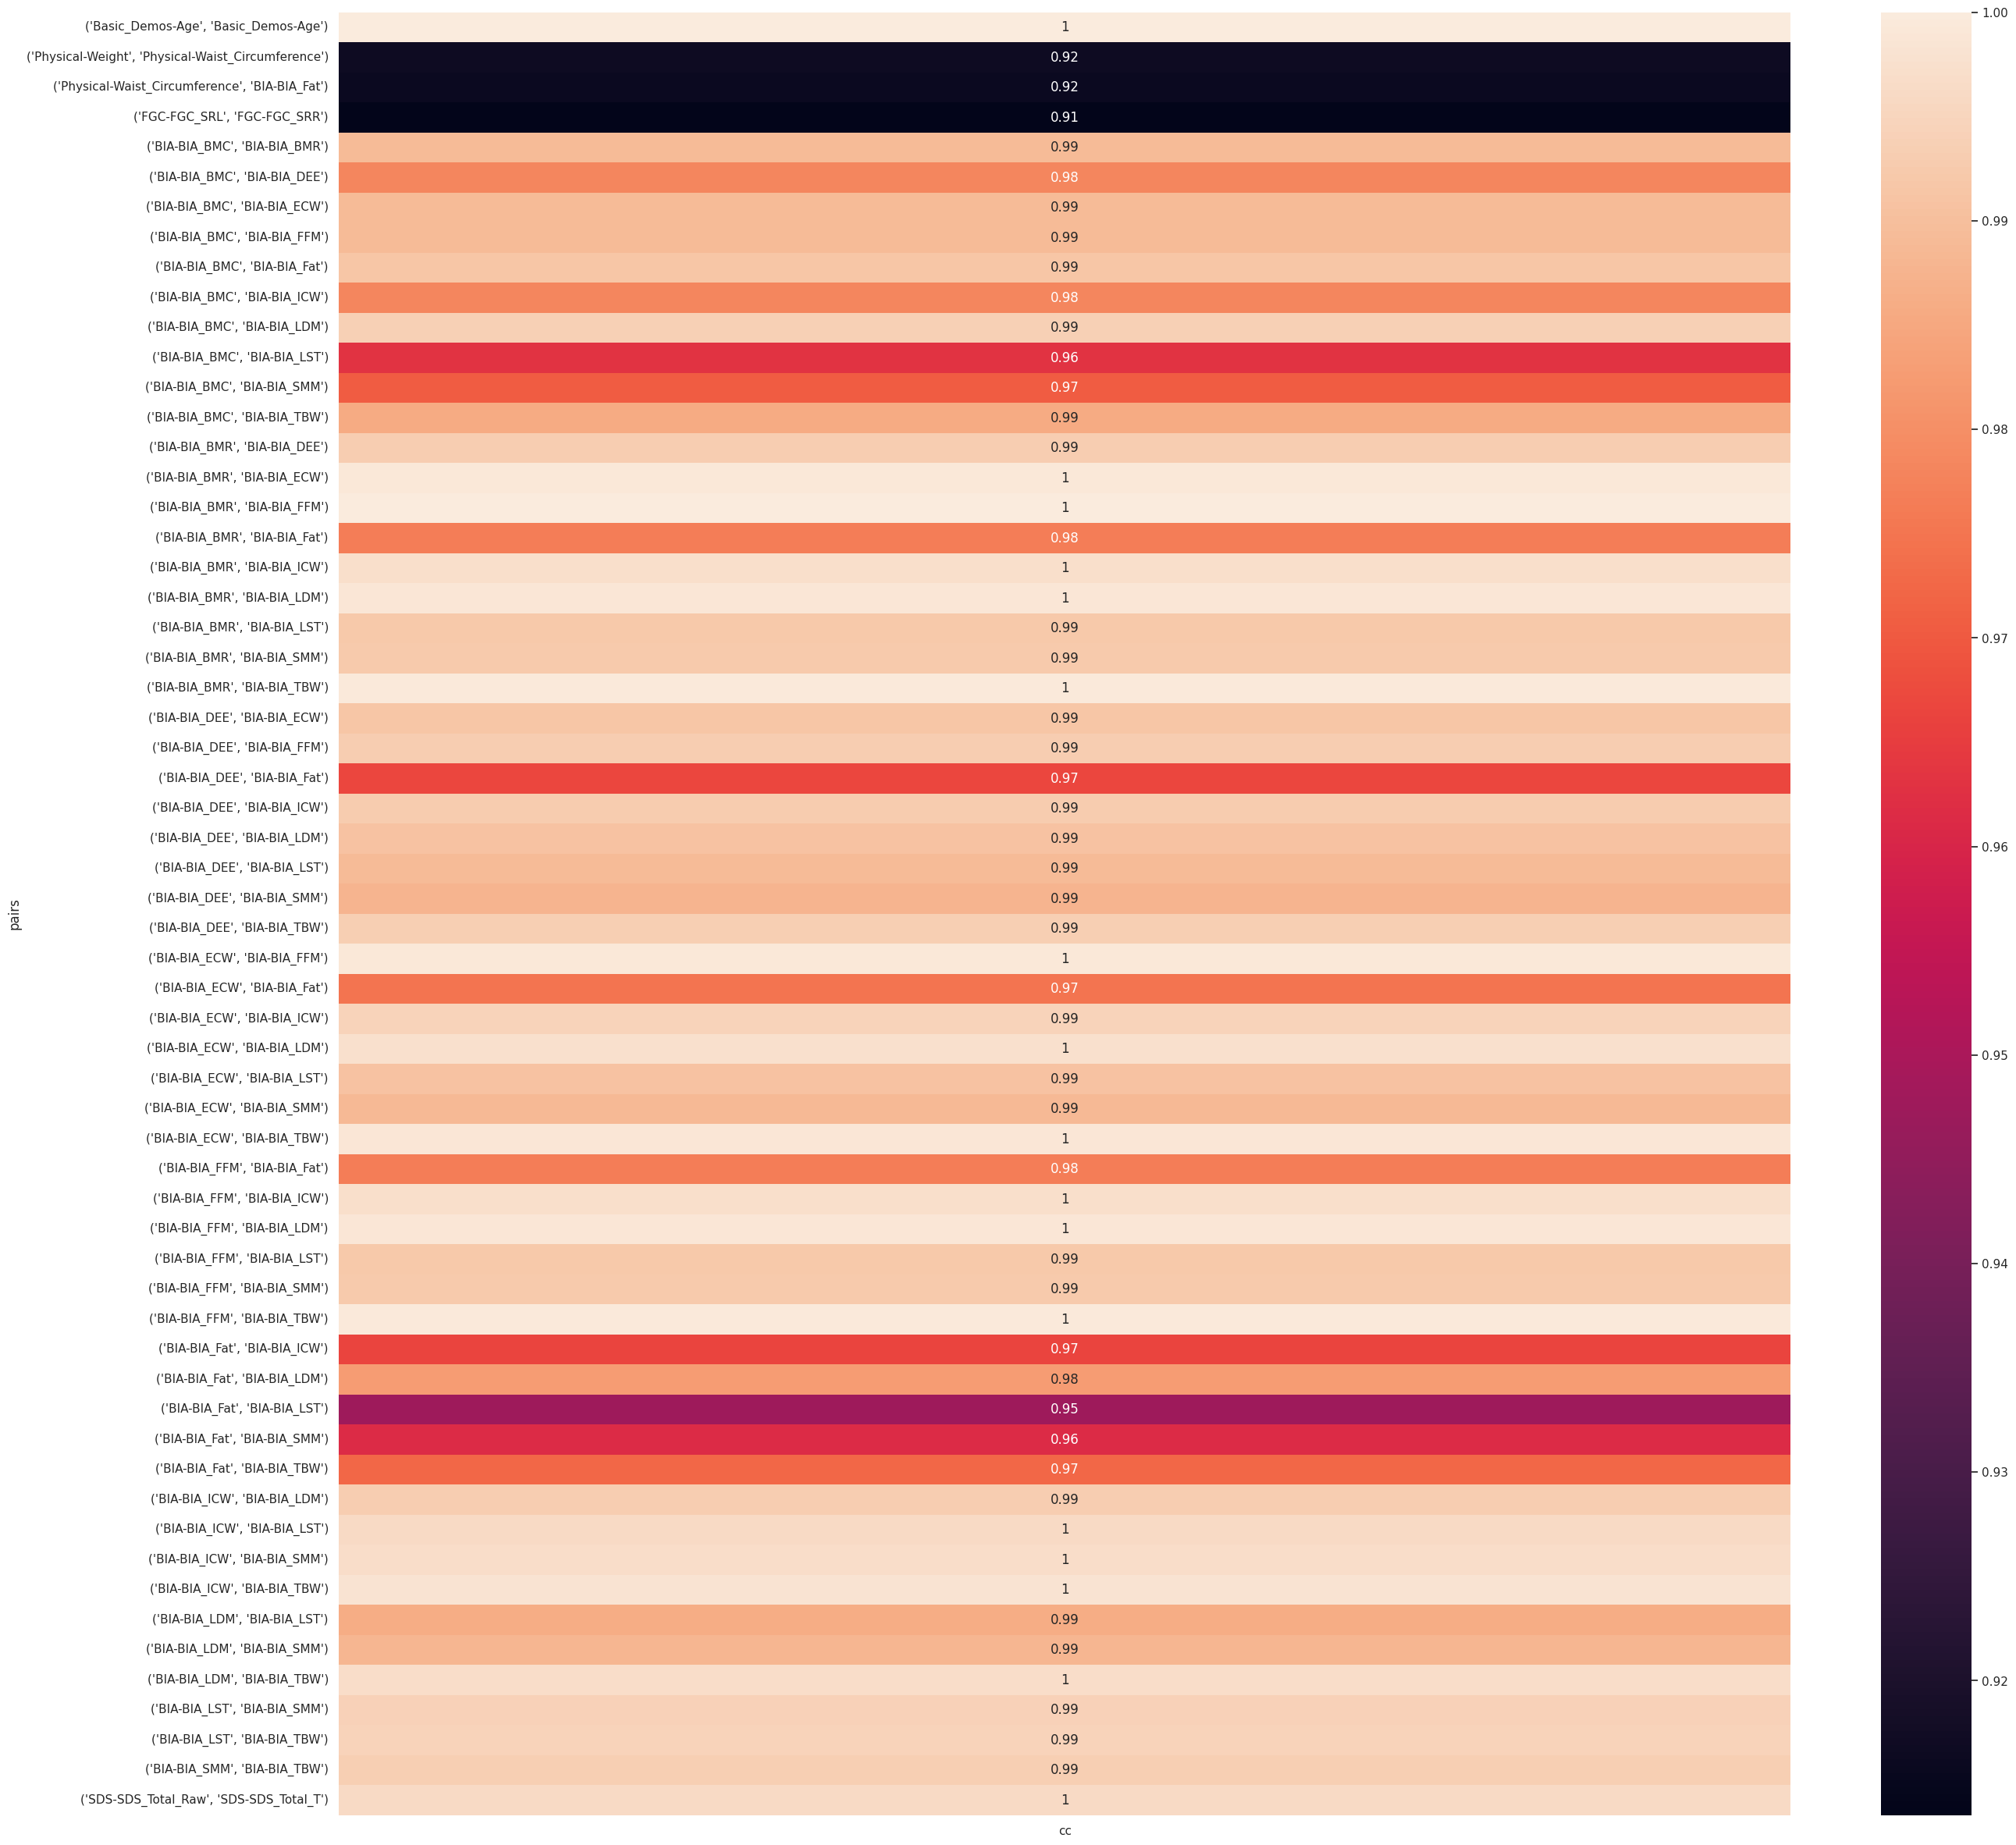

In [29]:
#To see the features most correlated with each other:


top_corr2 = df2[(df2.cc>=.90)]

sns.set(rc={'figure.figsize':(30,30)})
sns.heatmap(top_corr2, annot=True);

In [30]:
#dropping the same columns from the test set
#test_ds = test_ds.drop(columns=
                        # ['SDS-SDS_Total_Raw', 
                        #  'BIA-BIA_ECW', 
                          #'BIA-BIA_ICW',
                         # 'Physical-Height', 
                          #'Physical-Weight',
                          #'BIA-BIA_FFM', 
                          #'BIA-BIA_LDM', 
                          #'BIA-BIA_TBW',
                          #'BIA-BIA_SMM',
                          #'BIA-BIA_DEE', 
                          #'BIA-BIA_Fat', 
                          #'BIA-BIA_LST'
                          
                         #])

##### Actigraphy data (train_ts)

Only 996 of the test subjects are in both train_ds and train_ts, meaning only this number of participants have both demographic data as well as actigraphy data.

In [31]:
#merging train_ds and train_ts left on the ID values in train_ds, as there are more than those contained in train_ts
merged_train = pd.merge(train_ds, train_ts, how="left", on='id')

# doing same for the test data
merged_test = pd.merge(test_ds, test_ts, how="left", on='id')

merged_train.head()


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,Stat_86,Stat_87,Stat_88,Stat_89,Stat_90,Stat_91,Stat_92,Stat_93,Stat_94,Stat_95
0,00008ff9,Fall,5,0,Winter,51.0,Fall,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,48.0,46.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,56.5,75.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,56.0,81.6,NaN,...,1.546979,4.004276,89.751656,0.0,2633.25,4188.5,8.611000e+13,7.0,3.0,85.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
test_ids = merged_test['id'].to_list()

In [33]:
merged_train = merged_train.drop(columns=['id'])
merged_test = merged_test.drop(columns=['id'])

##### Feature(s): PreInt_EduHx-Season, SDS-Season, PAQ_C-Season, PAQ_A-Season, BIA-Season, FGC-Season, Fitness_Endurance-Season, Physical-Season, CGAS-Season, Basic_Demos-Enroll_Season, PCIAT-Season

There are multiple features in the data that refer to **seasons**. To make these feature values interpretable in modeling, I label encode them so that each season name will be replaced by a corresponding integer.

In [34]:
#label encoding all features that are seasons

from sklearn import preprocessing 

label_encoder = preprocessing.LabelEncoder() 
   
merged_train['PreInt_EduHx-Season']= label_encoder.fit_transform(merged_train['PreInt_EduHx-Season'])
merged_train['SDS-Season']= label_encoder.fit_transform(merged_train['SDS-Season'])
merged_train['PAQ_C-Season']= label_encoder.fit_transform(merged_train['PAQ_C-Season'])
merged_train['PAQ_A-Season']= label_encoder.fit_transform(merged_train['PAQ_A-Season'])
merged_train['BIA-Season']= label_encoder.fit_transform(merged_train['BIA-Season'])
merged_train['FGC-Season']= label_encoder.fit_transform(merged_train['FGC-Season'])
merged_train['Fitness_Endurance-Season']= label_encoder.fit_transform(merged_train['Fitness_Endurance-Season'])
merged_train['Physical-Season']= label_encoder.fit_transform(merged_train['Physical-Season'])
merged_train['CGAS-Season']= label_encoder.fit_transform(merged_train['CGAS-Season'])
merged_train['Basic_Demos-Enroll_Season']= label_encoder.fit_transform(merged_train['Basic_Demos-Enroll_Season'])

  
#To view the results of this encoding on one of these features:
merged_train['PreInt_EduHx-Season'].unique() 




array([0, 2, 3, 4, 1])

In [35]:
# doing same for test set
 
merged_test['PreInt_EduHx-Season']= label_encoder.fit_transform(merged_test['PreInt_EduHx-Season'])
merged_test['SDS-Season']= label_encoder.fit_transform(merged_test['SDS-Season'])
merged_test['PAQ_C-Season']= label_encoder.fit_transform(merged_test['PAQ_C-Season'])
merged_test['PAQ_A-Season']= label_encoder.fit_transform(merged_test['PAQ_A-Season'])
merged_test['BIA-Season']= label_encoder.fit_transform(merged_test['BIA-Season'])
merged_test['FGC-Season']= label_encoder.fit_transform(merged_test['FGC-Season'])
merged_test['Fitness_Endurance-Season']= label_encoder.fit_transform(merged_test['Fitness_Endurance-Season'])
merged_test['Physical-Season']= label_encoder.fit_transform(merged_test['Physical-Season'])
merged_test['CGAS-Season']= label_encoder.fit_transform(merged_test['CGAS-Season'])
merged_test['Basic_Demos-Enroll_Season']= label_encoder.fit_transform(merged_test['Basic_Demos-Enroll_Season'])

 

##### Feature(s): sii (target)

In [36]:
merged_train['sii'].isnull().sum()


1224

There are a lot of rows in the data that have null values as the target. Therefore, without preprocessing further, fully supervised modeling techiniques would not be possible on this data.

In [37]:
#remove target for now, while I impute other missing values
target_col = merged_train.pop('sii') 

In [38]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(missing_values=np.nan, n_neighbors=8)
filled_array = knn_imputer.fit_transform(merged_train)
filled_train = pd.DataFrame(filled_array, columns = merged_train.columns)

In [39]:
#doing same to test set
filled_test_array = knn_imputer.transform(merged_test)
filled_test = pd.DataFrame(filled_test_array, columns = merged_test.columns)

## Modeling

With sklearn's SelfTrainingClassifier, you can use a regular classifier in a semi-supervised way. I am going to use the best performing model from the supervised modeling techniques to do this.

In [40]:
#adding back in the target column
filled_train.insert(len(filled_train.columns), 'sii', target_col)

# filling missing target values with -1 for semi-supervised model
filled_train = filled_train.fillna(value=-1)

In [41]:
X_train_ss=filled_train.drop(columns=['sii'])
y_train_ss=filled_train['sii'].values
X_test_ss=filled_train.drop(columns=['sii'])
y_test_ss=filled_train['sii'].values
    


In [42]:
#scaler = StandardScaler()
#scaled_X_train= scaler.fit_transform(X_train_ss)
#scaled_X_test= scaler.fit_transform(X_test_ss)


In [43]:

    
abc = AdaBoostClassifier()
    
# Specify Self-Training model parameters
self_training_model_1 = SelfTrainingClassifier(base_estimator=abc,
                                              threshold=0.7,
                                              criterion='threshold', 
                                              max_iter=100, 
                                              verbose=True )


st_1 = self_training_model_1.fit(X_train_ss, y_train_ss)

In [44]:
preds_st_1 = st_1.predict(X_test_ss)
cohen_kappa_score(y_test_ss, preds_st_1, weights='quadratic')

0.20189221398493395

In [45]:

    
hgb = HistGradientBoostingClassifier()
    
# Specify Self-Training model parameters
self_training_model_2 = SelfTrainingClassifier(base_estimator=hgb,
                                              threshold=0.7,
                                              criterion='threshold', 
                                              max_iter=100, 
                                              verbose=True )



st_2 = self_training_model_2.fit(X_train_ss, y_train_ss)

End of iteration 1, added 643 new labels.
End of iteration 2, added 363 new labels.
End of iteration 3, added 138 new labels.
End of iteration 4, added 41 new labels.
End of iteration 5, added 11 new labels.
End of iteration 6, added 4 new labels.
End of iteration 7, added 6 new labels.
End of iteration 8, added 2 new labels.
End of iteration 9, added 2 new labels.
End of iteration 10, added 1 new labels.
End of iteration 11, added 1 new labels.
End of iteration 12, added 1 new labels.
End of iteration 13, added 1 new labels.
End of iteration 14, added 1 new labels.


In [46]:
preds_st_2 = st_2.predict(X_test_ss)
cohen_kappa_score(y_test_ss, preds_st_2, weights='quadratic')

0.7239993616569931

In [47]:

    
xgb = XGBClassifier()
    
# Specify Self-Training model parameters
self_training_model3 = SelfTrainingClassifier(base_estimator=xgb,
                                              threshold=0.7,
                                              criterion='threshold', 
                                              max_iter=100, 
                                              verbose=True )


st_3 = self_training_model3.fit(X_train_ss, y_train_ss)

End of iteration 1, added 678 new labels.
End of iteration 2, added 384 new labels.
End of iteration 3, added 98 new labels.
End of iteration 4, added 21 new labels.
End of iteration 5, added 16 new labels.
End of iteration 6, added 9 new labels.


In [48]:
preds_st_3 = st_3.predict(X_test_ss)
cohen_kappa_score(y_test_ss, preds_st_3, weights='quadratic')

0.7252442273534636

Of the different model types used with SelfTrainingClassifier in a semi-supervised way, it appears that the XGBoostingClassifier model performs the best.

#### Hyperparameter Tuning

#### Hyperparameter Tuning with GridSearchCV

The best performing model so far, in terms of quadratic weighted kappa score, was the __ model. By tuning the hyperparameters of this model, can this metric be improved even further?

In [49]:
# # Create a scorer for quadratic weighted kappa
# qwk_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# # Define the self-training model
# model = SelfTrainingClassifier(base_estimator=hgb)

# # Define hyperparameter distribution
# param_dist = {
#     'base_estimator__max_depth': [3, 5, 10, None],
#     'threshold': [0.7, 0.5, 0.3],
# }

# # scoring = cohen_kappa_score(X_test, y_test, weights='quadratic')
# # Perform random search
# gridsearch = GridSearchCV(estimator=model,
#                                    param_grid=param_dist,
# #                                    n_iter=100,
#                                    cv=5,
#                                    # scoring=qwk_scorer,
#                                  )
# gridsearch.fit(X_train_ss, y_train_ss)

# # Report best score and parameters
# print(f"Best score: {gridsearch.best_score_:.3f}")
# print(f"Best parameters: {gridsearch.best_params_}")

# # Evaluate on test set
# best_model = gridsearch.best_estimator_
# qwk = best_model.score(X_test_ss, y_test_ss)
# print(f"Test set Quadratic Weighted Kappa Score: {qwk:.3f}")


In [50]:
#tuned_preds = best_model.predict(X_test_ss)#

In [51]:
#cohen_kappa_score(y_test_ss, tuned_preds, weights='quadratic')

This hyperparameter tuning attempt does not appear to have improved model performance.

### Generating predictions for submission

In [52]:
# #standardize
#filled_test

#scaler = StandardScaler()
#scaled_test = scaler.fit_transform(filled_test)

In [53]:
final_preds = st_2.predict(filled_test)

In [54]:
submission = pd.DataFrame({'id': test_ids,'sii': final_preds})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

# Check the first few rows of the submission
print(submission.head())

         id  sii
0  00008ff9  2.0
1  000fd460  0.0
2  00105258  0.0
3  00115b9f  1.0
4  0016bb22  0.0


## Results & Conclusion

In [55]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test_ss, preds_st_2)
# np.set_printoptions(precision=2)

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

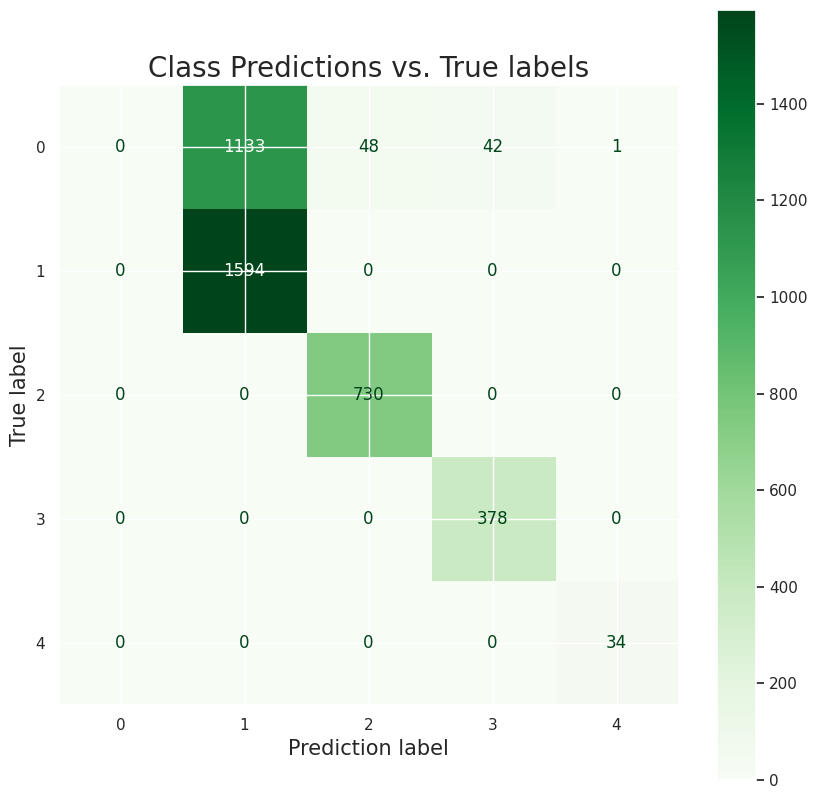

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
cm_2 = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix)
cm_2.plot(cmap=plt.cm.Greens, ax=ax)
plt.xlabel('Prediction label',fontsize=15)
plt.ylabel('True label',fontsize=15)
plt.title('Class Predictions vs. True labels',fontsize=20)
plt.savefig('conf_matrix.png') ;

#### Results:
The best model, a SelfTrainingClassifier with XGBClassifier as the base model, received a quadratic weighted kappa score of about **0.725** on the unseen portion of the training data. 

#### Limitations:
- The data provided for this task is very sparse, containing a large amount of null values for most features, including the target (sii). This means that in order to accomplish this project task, either an unsupervised learning model needs to be used, which can often be difficult to evaluate, or these values need to be dealt with prior to modeling. I chose a semi-supervised modeling approach that would use existing target values to first predict and fill the missing values before being used to generate test set predictions. However effective this method may be, we don't know for sure if these predicted target values are correct, or if the imputed missing values for the other features are accurate. When this filled-in data is used for modeling, the model may detect patterns that are not really there or not as strong as they are in reality. This can have unseen impacts on the results of modeling.
- Similarly to the previous point, some of the features present in the training dataset (train_ds), are not present in the test dataset (test_ds). This means that if the model relies on these features during training to make predictions, then the model will not be able to make predictions as well for the test dataset. 
- Another limitation of the data is the very large number of features. This increases the complexity of the data, which can affect the modeling process. More complex data can lead to model overfitting and thus the model will not perform as well on unseen data. I used multiple techniques to reduce the impact of this, however there may be other techniques that would work even better and reduce this complexity even further.

#### Next Steps:
Although the final model performed very well, it is possible that this result could be improved even further by trying out different techniques in pre-processing and modeling. In future research, this result may be improve by:
- including data from a greater number of test subjects
- including more complete data for test subjects
- experimenting with other ways of imputing/filling missing values including target values (sii)
- experimenting with other types of models for multiclass classification
